# *clone2vec* simple tutorial

In [34]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sclitr as sl

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

Firstly, let's take a look at the dataset.

In [3]:
adata = sl.datasets.Weinreb_in_vitro()

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


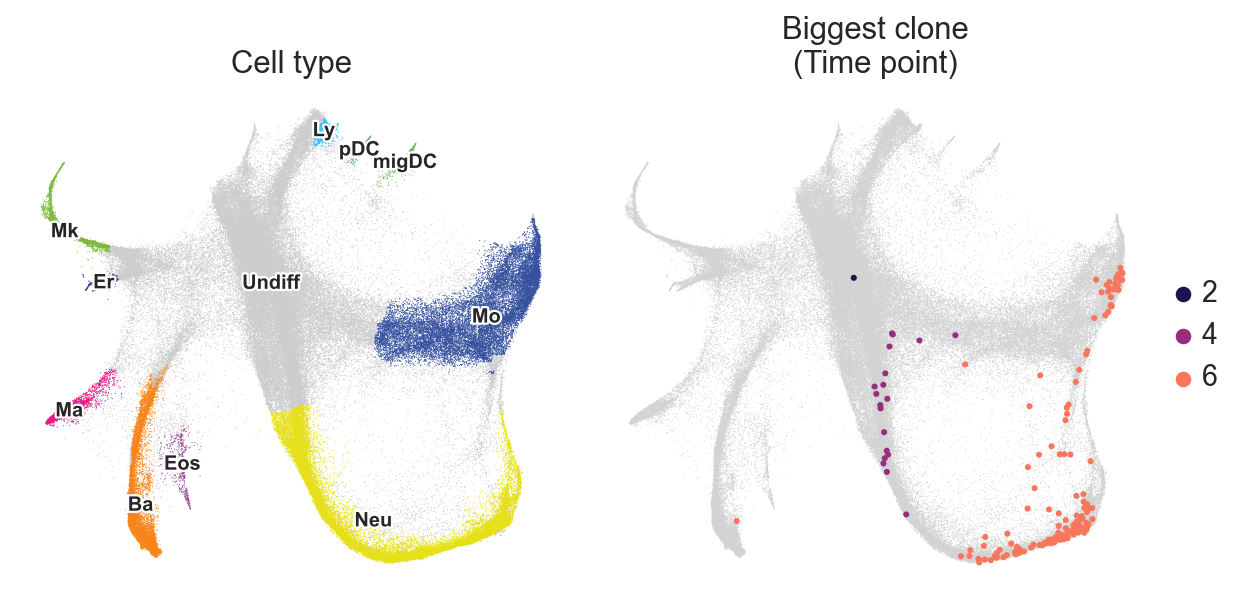

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sc.pl.embedding(
    adata,
    basis="X_spring",
    color="Cell type annotation short",
    frameon=False,
    title="Cell type",
    legend_loc="on data",
    legend_fontsize=9,
    legend_fontoutline=2,
    ax=axes[0],
    show=False,
)

sl.pl.clone(
    adata,
    clone_col="Clone",
    clone_name=adata.obs["Clone"].value_counts().index[1],
    basis="X_spring",
    title="Biggest clone",
    kwargs_clone={"color": "Time point"},
    ax=axes[1],
)

fig.tight_layout()

Secondly, let's explore the distribution of clone sizes.

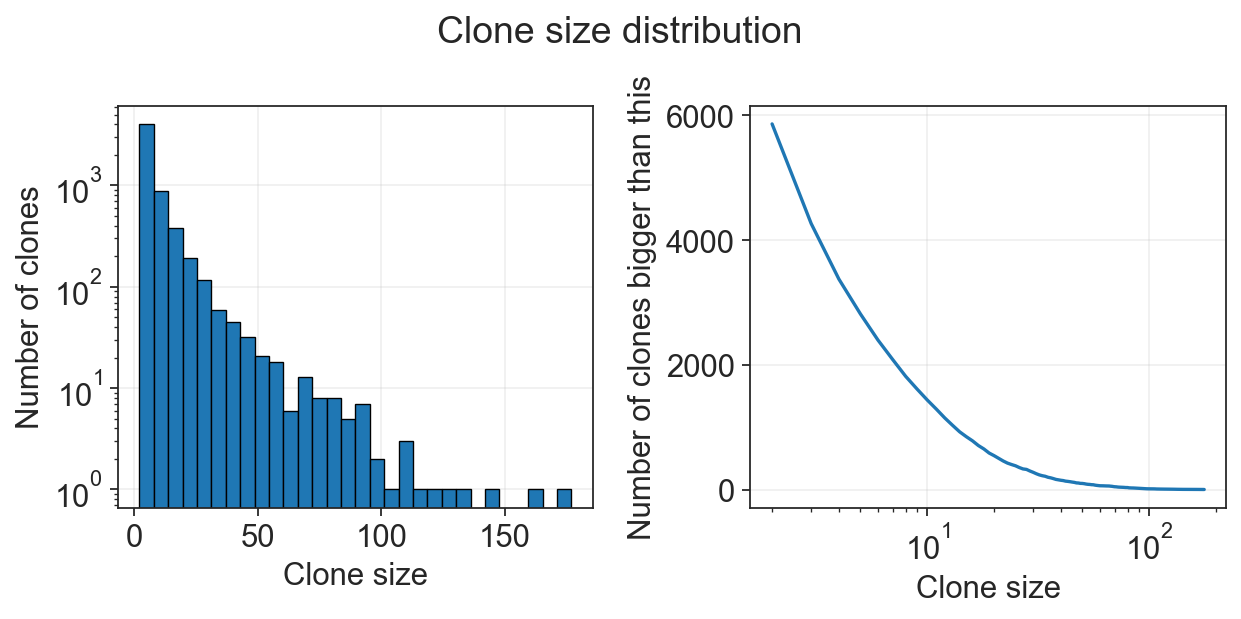

In [38]:
sl.pl.basic_stats(adata, obs_name="Clone", title="Clone size distribution")

Now, let's find clonally labeled nearest neighbours for each cell.

In [6]:
sl.tl.clonal_nn(
    adata,
    obs_name="Clone",
    use_rep="X_pca_harmony",
    min_size=5,
    tqdm_bar=True,
)

100%|██████████| 130887/130887 [02:02<00:00, 1065.89it/s]


Now we have sparce matrix matrix with number of each clone in *k* (default `k = 15`) nearest neighbours for each cell in `adata.obsm["bag-of-clones"]` and clone names in `adata.uns["bag-of-clones_names"]`.

In [7]:
clones = sl.tl.clone2vec(
    adata,
    obs_name="Clone",
    fill_ct="Cell type annotation short",
    device="cuda:0",
    n_epochs=50,
)

100%|██████████| 50/50 [13:15<00:00, 15.90s/it]
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


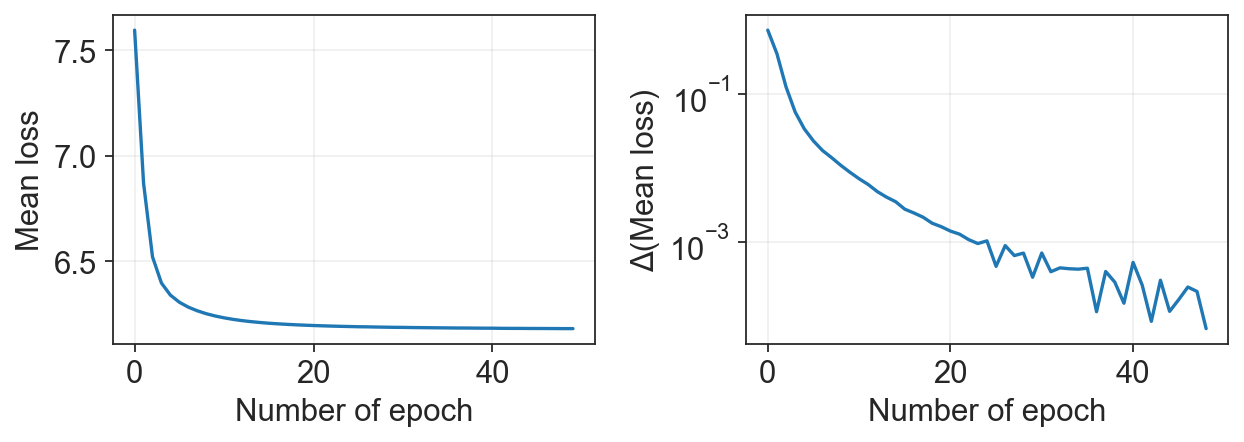

In [39]:
sl.pl.epochs_loss(clones)

Now, let's construct kNN-graph and UMAP based on latent representation of the clones.

In [9]:
sc.pp.neighbors(clones, use_rep="word2vec", n_neighbors=15)
sc.tl.umap(clones)

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/umap/distances.

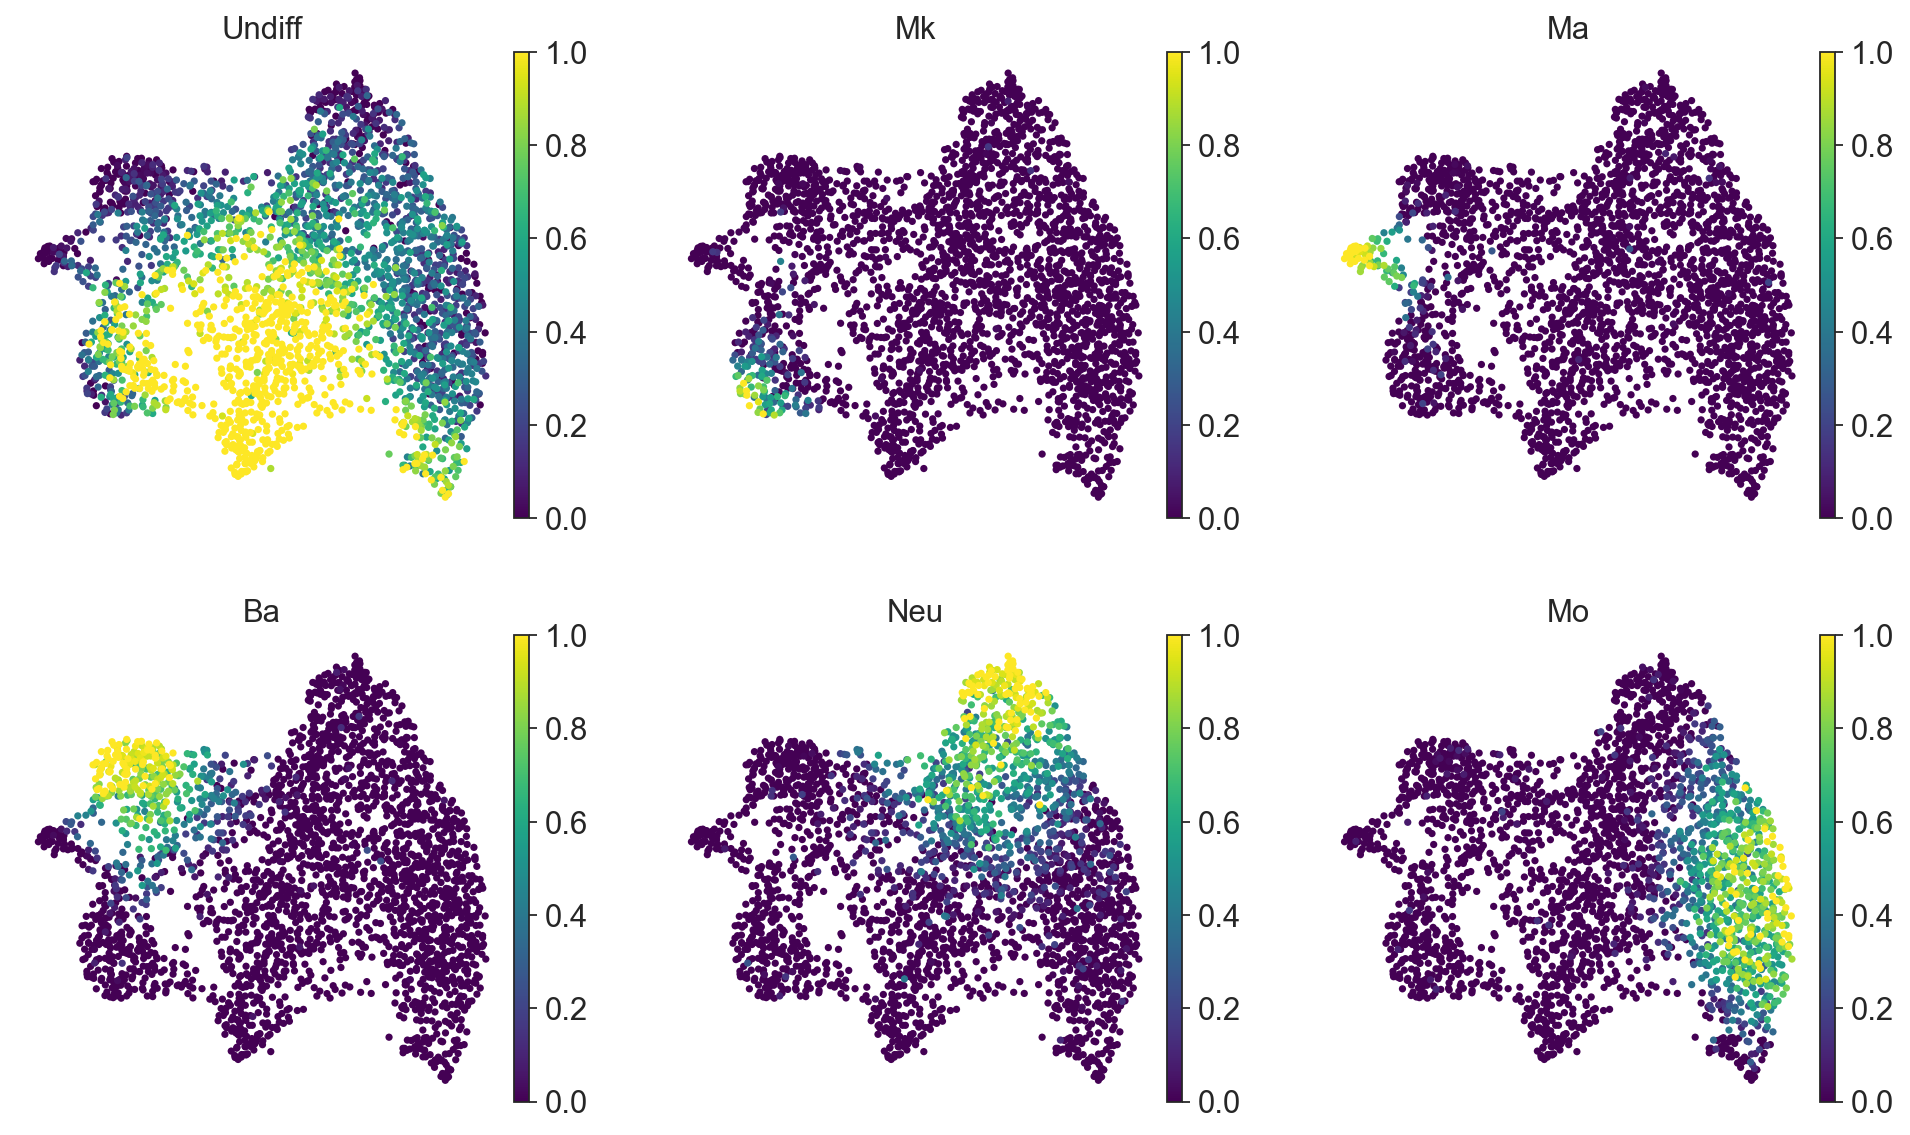

In [40]:
sc.pl.umap(
    clones,
    color=["Undiff", "Mk", "Ma", "Ba", "Neu", "Mo"],
    layer="frequencies",
    frameon=False,
    cmap="viridis",
    ncols=3,
)

And finally let's construct clustering and define mixed clonal cluster:

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


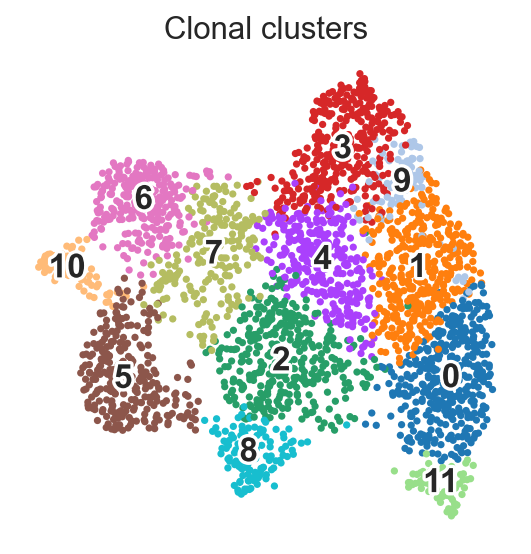

In [41]:
sc.tl.leiden(clones, resolution=1)

sc.pl.umap(
    clones,
    color="leiden",
    frameon=False,
    title="Clonal clusters",
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=3
)

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


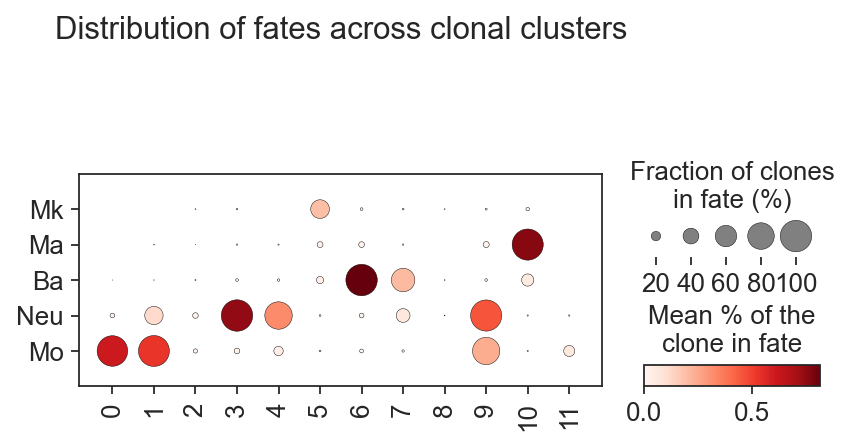

In [42]:
sc.pl.dotplot(
    clones,
    var_names=["Mk", "Ma", "Ba", "Neu", "Mo"],
    groupby="leiden",
    layer="frequencies",
    colorbar_title="Mean % of the\nclone in fate",
    cmap="Reds",
    swap_axes=True,
    size_title="Fraction of clones\nin fate (%)",
    title="Distribution of fates across clonal clusters",
    dot_max=1,
)

And now we can map it back onto the cells' manifold.

In [13]:
sl.tl.transfer_clonal_annotation(
    adata,
    clones,
    adata_clone_name="Clone",
    adata_obs_name="Clonal cluster",
    clones_obs_name="leiden",
    fill_values="NA",
)

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colorm

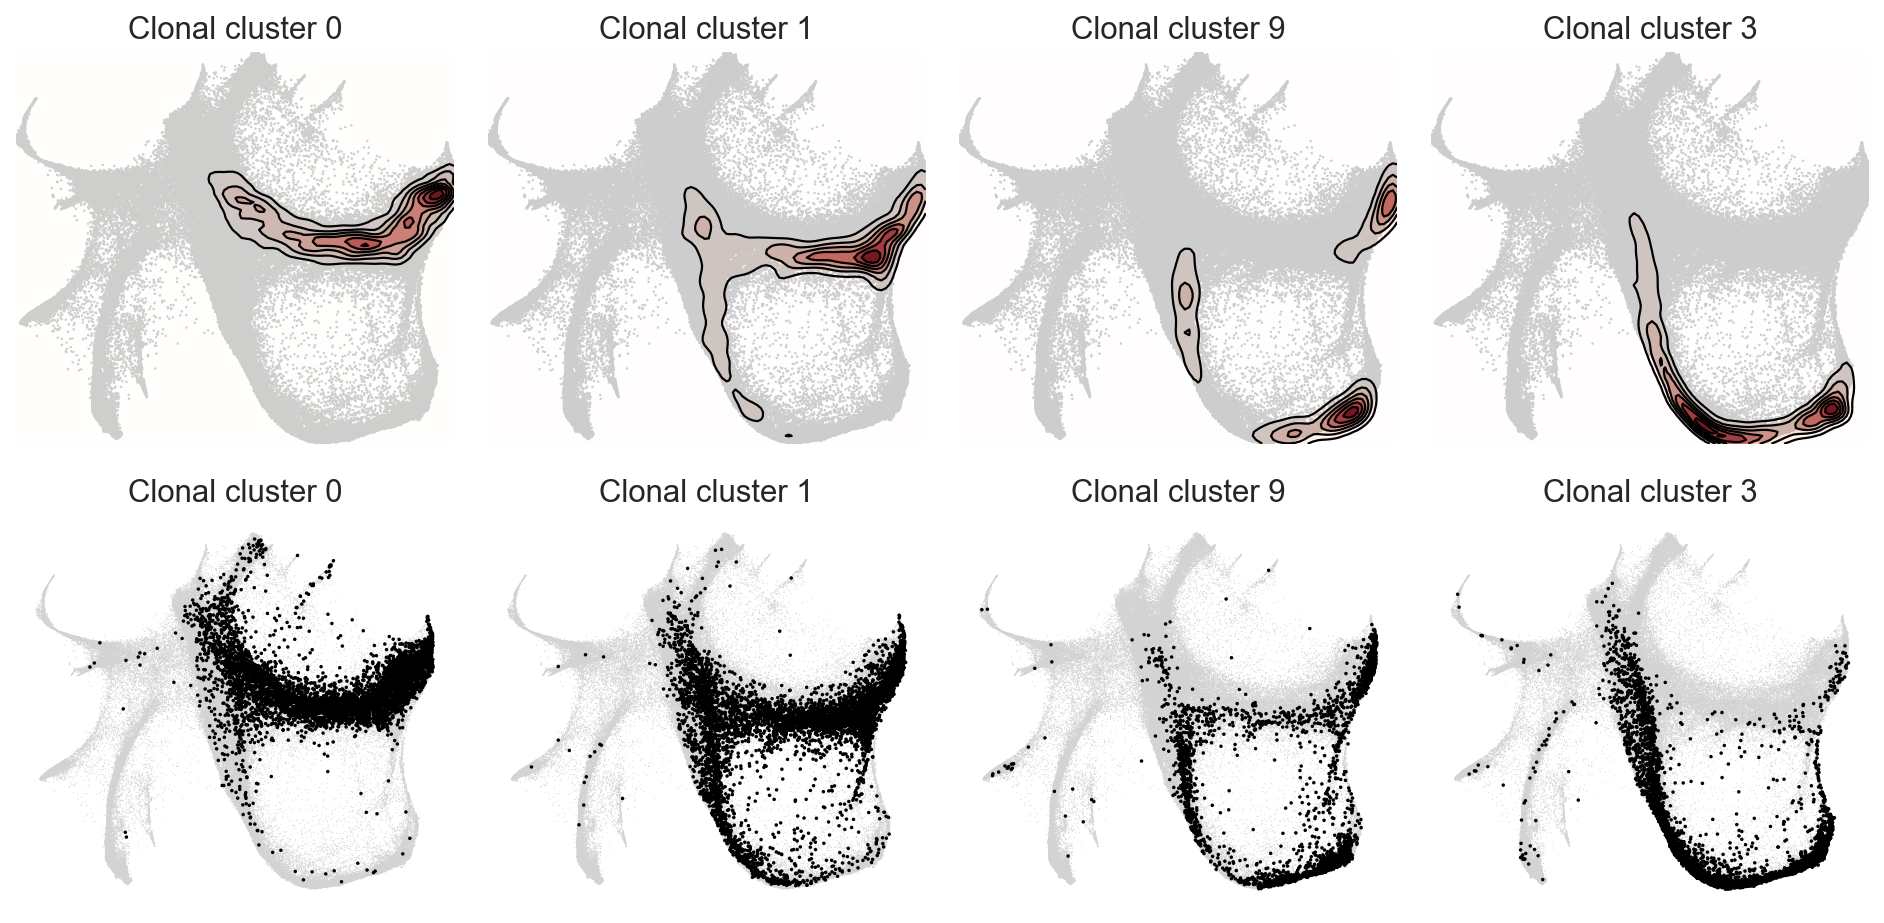

In [43]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12, 6))

for i, clonal_cluster in enumerate(["0", "1", "9", "3"]):
    sl.pl.kde(
        adata,
        basis="X_spring",
        groupby="Clonal cluster",
        group=clonal_cluster,
        title=f"Clonal cluster {clonal_cluster}",
        ax=axes[0, i],
    )

    sl.pl.clone(
        adata,
        clone_col="Clonal cluster",
        clone_name=clonal_cluster,
        basis="X_spring",
        title=f"Clonal cluster {clonal_cluster}",
        s=10,
        ax=axes[1, i],
    )
    
fig.tight_layout()

And finally we can prepare clones2cells-friendly csv-files.

In [33]:
df_gex = sl.pp.prepare_clones2cells(
    adata,
    embedding_type="GEX",
    clonal_obs="Clone",
    keep_obs=["Time point", "Cell type annotation"],
    dimred_name="X_spring",
)

df_clones = sl.pp.prepare_clones2cells(
    clones,
    embedding_type="clone2vec",
    keep_obs=["leiden"],
)

df_gex.to_csv("GEX.csv")
df_clones.to_csv("clone2vec.csv")